In [2]:
from os import sep
import numpy as np
import argparse
from enum import Enum
import statistics
import sys
import matplotlib
import matplotlib.pyplot as plt
import csv
plt.rcParams['text.usetex'] = True

# Tweaking Playground for the Ising Model Simulator
   3/12/2022 Zhaoyi Li

In [3]:
class lattice:

	# initialization of the lattice and other relevant variables
	# Variables
	# @S [length, width] of the lattice
	# @J coupling strength (default all -1 for ferro)
	def __init__(self, S, T, J):
		self.S = S
		self.T = T
		self.J = J
		self.spins = np.ones(S,dtype=int)
		self.bonds = self.J*np.array([np.ones(S),np.ones(S)])
		self.energy = self.update_energy()

	def update_energy(self): #Calculate H energy
		S=self.S
		energy = 0
		for i in range(S[0]):
			for j in range(S[1]):
				energy += self.bonds[0,i,j]*self.spins[i][j]*self.spins[divmod(1+i,S[0])[1]][j]
				energy += self.bonds[1,i,j]*self.spins[i][j]*self.spins[i][divmod(1+j,S[1])[1]]
		self.energy=energy
		return energy
	

	#get state number (2^n^n) states from 0 to 2^n^n-1
	def get_state_number(self):
		conversionMat = (2**np.arange(0, self.S[0]**2, 1, dtype=int))[::-1]
		return np.matmul(conversionMat,((self.spins+1)//2).flatten())
	#uncorrelated error distribution for all spins
	def random_initial_condition(self, seed=0): 
		S=self.S	
		for i in range(S[0]):
			for j in range(S[1]):
				if np.random.random_sample() < 1/2:
					self.spins[i][j] = -1
				else:
					self.spins[i][j] = 1
	#print currect configuration (deprecated)
	def print(self):
		S=self.S
		print_out = []
		for i in range(2*S[0]):
			a_line = []
			for j in range(2*S[1]):
				a_line.append(" ")
				print_out.append(a_line)
		print(self.spins)
		print(3)

	#Evolve 1 step using metropolis algorithm
	def make_step(self): 
		S = self.S
		#randomly flip i bit
		x = np.random.randint(S[0])
		y = np.random.randint(S[1])
		d_energy = 0
		#update the energy with four neighbors
		d_energy += self.bonds[0,x,y]*self.spins[x][y]*self.spins[divmod(x+1,S[0])[1]][y]
		d_energy += self.bonds[0,divmod(x-1,S[0])[1],y]*self.spins[x][y]*self.spins[divmod(x-1,S[0])[1]][y]
		d_energy += self.bonds[1,x,y]*self.spins[x][y]*self.spins[x][divmod(y+1,S[1])[1]]
		d_energy += self.bonds[1,x,divmod(y-1,S[1])[1]]*self.spins[x][y]*self.spins[x][divmod(y-1,S[1])[1]]
		d_energy *= -2 #calculating change in energy
	
		if d_energy <= 0: #rejection scheme
			self.spins[x][y] *= -1
			self.energy += d_energy
		else:  
			r = np.random.random() #update if accpeted
			if r < np.exp(-d_energy/self.T):
				self.spins[x][y] *= -1
				self.energy += d_energy 
	
	#Evolve n step using metropolis algorithm (sweep of n steps)
	def make_sweep(self, nsteps):
		for i in range(nsteps):
			self.make_step()

In [4]:
#variables:
#@rpt: number of steps for a sweep
def test_simulation(S, T, J, rpt):
	testlattice = lattice(S, T, J)
	testlattice.random_initial_condition()
	testlattice.energy = testlattice.update_energy()

	energy = np.zeros(rpt)
	magnetization = np.zeros(rpt)
	for i in range(rpt):
		if i % (rpt/10) == 0:
			print(".",flush=True,end='')
		for steps in range(1):
				testlattice.make_step()	
		energy[i] = testlattice.energy
		magnetization[i] = np.sum(testlattice.spins)

	#figure settings
	fig = plt.figure()
	ax = fig.add_subplot(111)
	ax.pcolormesh(testlattice.spins,vmin=-1, vmax=1)
	ax.set_aspect(1)
	plt.show()
	return energy, magnetization

In [5]:
#Wait for a couple of sweeps before taking one snapshot per sweep
#variables:
#@rpt: number of steps for a sweep
def test_simulation_multiple_steps(S, T, J, stepSize, waitSweeps, rptSweeps):
	testlattice = lattice(S, T, J)
	testlattice.random_initial_condition()
	testlattice.energy = testlattice.update_energy()

	energy = np.zeros(rptSweeps)
	magnetization = np.zeros(rptSweeps)
	state = np.zeros(rptSweeps)
	#wait for waitSweeps
	for i in range(waitSweeps):
		testlattice.make_sweep(stepSize)

	#repeat for rptSweeps and sample for each sweeps
	for i in range(rptSweeps):
		if i % (rptSweeps//100) == 0:
			print(".",flush=True,end='')
		testlattice.make_sweep(stepSize)
		
		#recording of state, e, and m
		energy[i] = testlattice.energy
		magnetization[i] = np.sum(testlattice.spins)
		state[i] = testlattice.get_state_number()
	#figure settings
	# fig = plt.figure()
	# ax = fig.add_subplot(111)
	# ax.pcolormesh(testlattice.spins,vmin=-1, vmax=1)
	# ax.set_aspect(1)
	# plt.show()
	return energy, magnetization, state

<h2> Comparison With Theoretical Distribution </h2>

(0.0, 1.0)

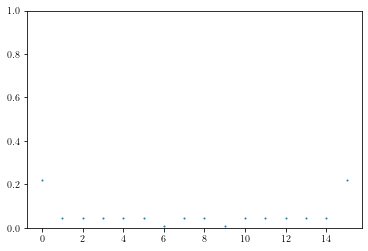

In [6]:
#Compute theoretical graph of histogrammatic distribution


import itertools

T= 5
n= 2
probabilities = np.zeros(2**(n**2))
for matrix in itertools.product([1, -1], repeat=9):
    # Reshape the flat matrix into a nxn array
    matrix = list(matrix)
    matrix = [matrix[i:i+n] for i in range(0, n**2, 3)]
    testlattice = lattice([n,n], T, -1)
    testlattice.spins=np.array(matrix)
    testlattice.update_energy()
    probabilities[testlattice.get_state_number()]= np.exp(-1/T*testlattice.energy)

fig_histogram = plt.figure()
ax1 = fig_histogram.add_subplot(1, 1, 1)

norm_p = np.linalg.norm(probabilities, ord=1)
ax1.plot(probabilities/norm_p,linestyle="",marker=".",markersize=2)
plt.ylim([0,1])

In [9]:
#Sampling test run on 3x3 grid with theory 
T = 5
J = -1
n = 2
S = [n,n]
energy, magnetization, state = test_simulation_multiple_steps(S,T,J,n**2,10,10000)

....................................................................................................

[ 1.  1.  1. ... 15. 15. 15.]


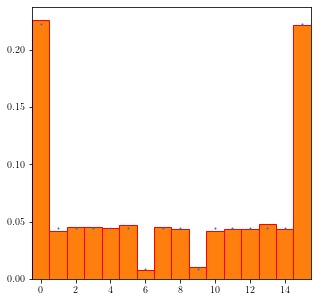

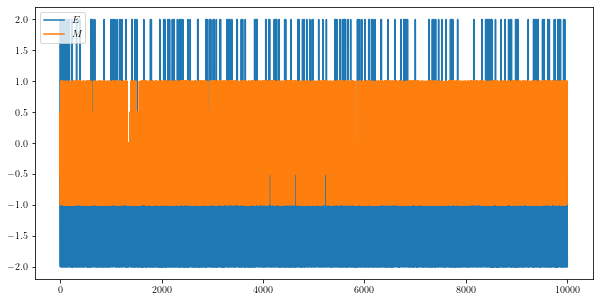

ImportError: cannot import name 'Stats' from 'scipy.stats' (/Users/VanLadmon/Library/Python/3.8/lib/python/site-packages/scipy/stats/__init__.py)

In [13]:
#plot histogram of states to check distribution. It could be obversed for n=2,3, numSweeps ~ 10000, there is very nice convergence.

weights= state/len(state)
print(state)
plt.rcParams['figure.figsize'] = (5,5)
fig_histogram = plt.figure()
ax1 = fig_histogram.add_subplot(1, 1, 1)
ax1.plot(probabilities/norm_p,linestyle="",marker="o",markersize=1)
bins=np.arange(-0.5,2**(n**2)+0.5,1)
ax1.hist(state, density=True, bins=bins, edgecolor='red')
fig_histogram.canvas.draw()
plt.xlim([-0.5,2**(n**2)-0.5])
plt.show()

plt.rcParams['figure.figsize'] = (10,5)
fig = plt.figure()
plt.plot(energy/(n**2))
plt.plot(magnetization/(n**2))
plt.legend(["$E$", "$M$"])
plt.show()

#analysis the data
import stats
from scipy.stats import Stats
(mean, variance, error, autocorrelation)= stats.Stats(energy)

..........

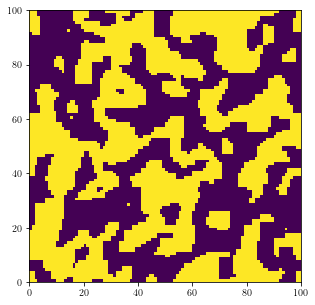

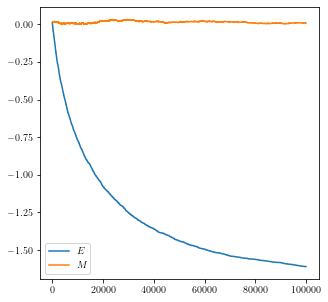

In [66]:
rpt = 100000
T = 0.1
J = -1
S = [100,100]
energy, magnetization = test_simulation(S,T,J,rpt)
plt.rcParams['figure.figsize'] = (5,5)
plt.plot(energy/(S[0]*S[1]))
plt.plot(magnetization/(S[0]*S[1]))
plt.legend(["$E$", "$M$"])
plt.show()

In [8]:
#variables:
#@rpt: number of steps for a sweep
def test_random_bond_simulation(S, T, J, p, rpt):
	testlattice = lattice(S, T, J)
	testlattice.random_initial_condition()
	testlattice.bonds = np.round(np.random.rand(2,100,100)-p+1/2)*2-1 #p\in(0,1) marks the probability for J = -1
	print("Lattice configuration:\n", testlattice.bonds)
	testlattice.energy = testlattice.update_energy()
	energy = np.zeros(rpt)
	magnetization = np.zeros(rpt)
	for i in range(rpt):
		if i % (rpt/10) == 0:
			print(".",flush=True,end='')
		for steps in range(1):
				testlattice.make_step()	
		energy[i] = testlattice.update_energy()
		magnetization[i] = np.sum(testlattice.spins)

	#figure settings
	fig = plt.figure()
	ax = fig.add_subplot(111)
	ax.pcolormesh(testlattice.spins,vmin=-1, vmax=1)
	ax.set_aspect(1)
	plt.show()
	return energy, magnetization

Lattice configuration:
 [[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
.

/var/folders/3n/s5gs3kt14yzf41kv6c3y1sxc0000gn/T/ipykernel_56658/1609783531.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  if r < np.exp(-d_energy/self.T):


.........

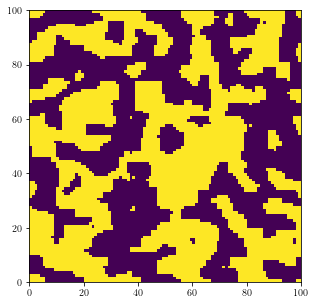

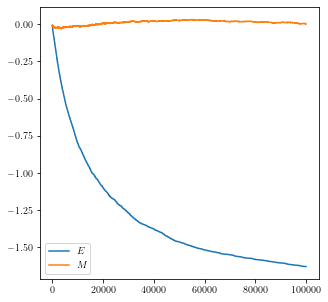

In [9]:
rpt = 100000
S = [100,100]
energy, magnetization = test_random_bond_simulation(S,0,-1,0,rpt)
plt.rcParams['figure.figsize'] = (5,5)
plt.plot(energy/(S[0]*S[1]))
plt.plot(magnetization/(S[0]*S[1]))
plt.legend(["$E$", "$M$"])
plt.show()

..........

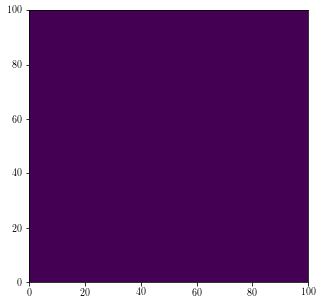

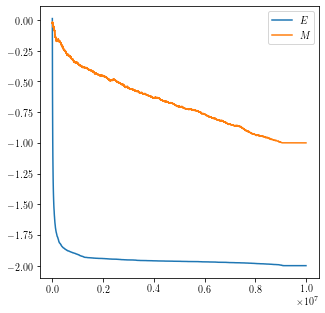

In [63]:
rpt = 10000000
S = [100,100]
# np.random.seed(3) #domain wall
energy, magnetization = test_simulation(S,0.1,-1,rpt)
plt.rcParams['figure.figsize'] = (5,5)
plt.plot(energy/(S[0]*S[1]))
plt.plot(magnetization/(S[0]*S[1]))
plt.legend(["$E$", "$M$"])
# np.mean(energy[rpt:2*rpt]/(S[0]*S[1]))

## Data Analysis

The following data is generated on a remote cluster with $\approx 10^8$ steps and $100$ samples.

In [24]:
# matplotlib.use("TkCairo")
with open('../rawdata/44947395_magnetization_100.csv', newline='') as csvfile:
	m1 = np.array(list(csv.reader(csvfile)))
with open('../rawdata/44947395_energy_100.csv', newline='') as csvfile:
	e1 = np.array(list(csv.reader(csvfile)))	
m1 = np.vectorize(int)(m1)
e1 = np.vectorize(int)(e1)

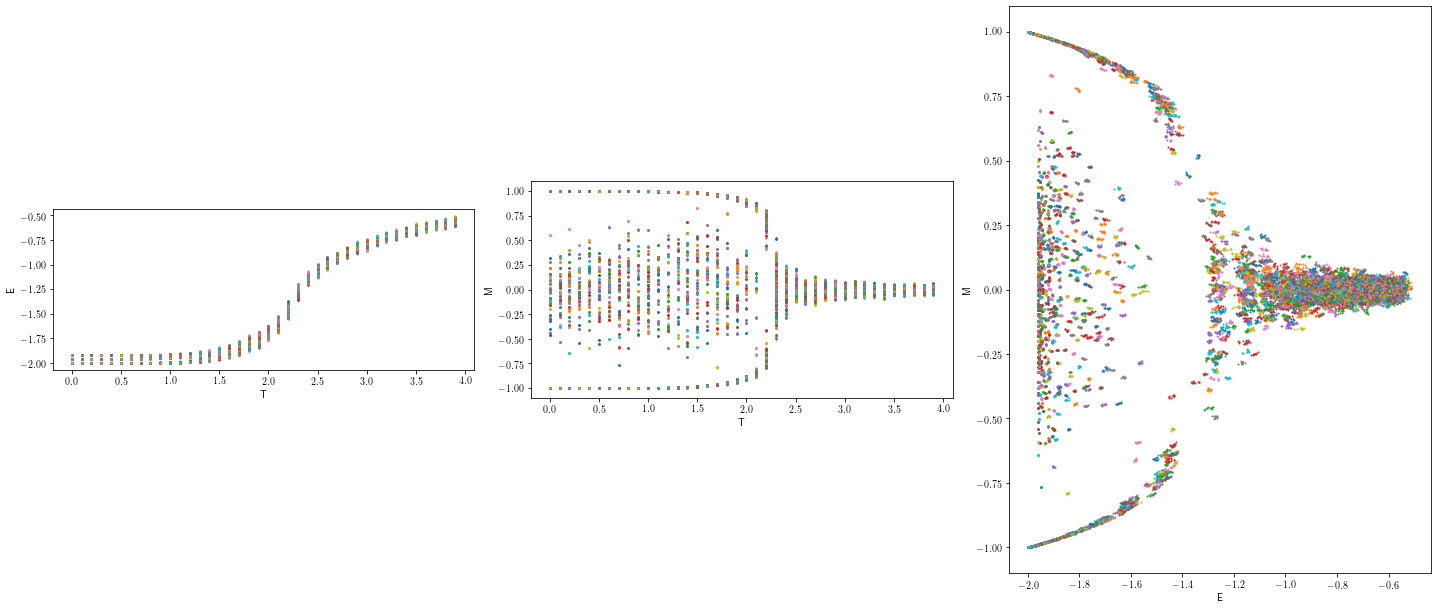

In [28]:
fig, ax = plt.subplots(1,3,figsize= (20,40))
for n in range(1000):
	ax[0].scatter(np.array(range(40))/10, e1[0:40,n]/10000, s = 1)
	ax[0].set_xlabel("T")
	ax[0].set_ylabel('E')
for n in range(1000):
	ax[1].scatter(np.array(range(40))/10, m1[0:40,n]/10000, s = 1)
	ax[1].set_xlabel("T")
	ax[1].set_ylabel('M')
	ax[2].scatter(e1[0:40,n]/10000, m1[0:40,n]/10000, s = 1)
	ax[2].set_xlabel("E")
	ax[2].set_ylabel('M')
# plt.rcParams['figure.figsize'] = (50,50)
fig.tight_layout()
ax[0].set_aspect(1)
ax[1].set_aspect(1)
ax[2].set_aspect(1)


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9]


<Figure size 360x360 with 0 Axes>

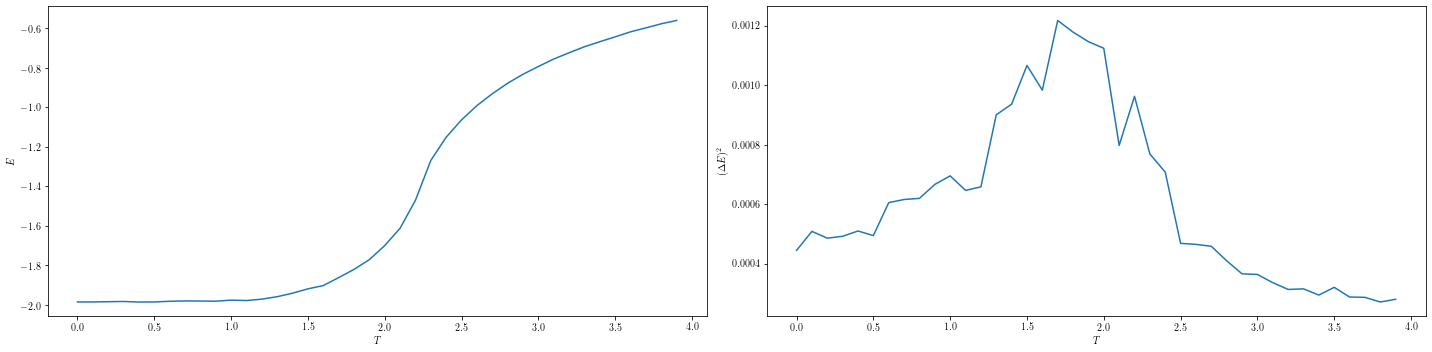

In [77]:
fig = plt.gcf()
fig, ax = plt.subplots(1,2)
ax[0].plot(np.array(range(40))/10, np.mean(e1, axis=1)[0:40]/10000)
ax[1].plot(np.array(range(40))/10, np.var(e1,axis=1)[0:40]/10000**2)
print(np.array(range(40))/10)
ax[0].set_xlabel("$T$")
ax[0].set_ylabel("$E$")
ax[1].set_xlabel("$T$")
ax[1].set_ylabel('$(\Delta E)^2$')
fig = plt.gcf()
fig.set_size_inches(20, 5, forward=True)
fig.tight_layout()

## Discussion

$\cdot$ Exhibits phase transition:
$T_c = \frac{2J}{k\ln{(1+\sqrt{2})}}\approx 2.27$

$\cdot$  Semistable states from E vs M diagram

## Adding Randomness

$\approx 10^4$ steps and $10000$ samples.

In [42]:
with open('../results/46665329_magnetization_1000.csv', newline='') as csvfile:
	m2 = np.array(list(csv.reader(csvfile)))
with open('../results/46665329_energy_1000.csv', newline='') as csvfile:
	e2 = np.array(list(csv.reader(csvfile)))

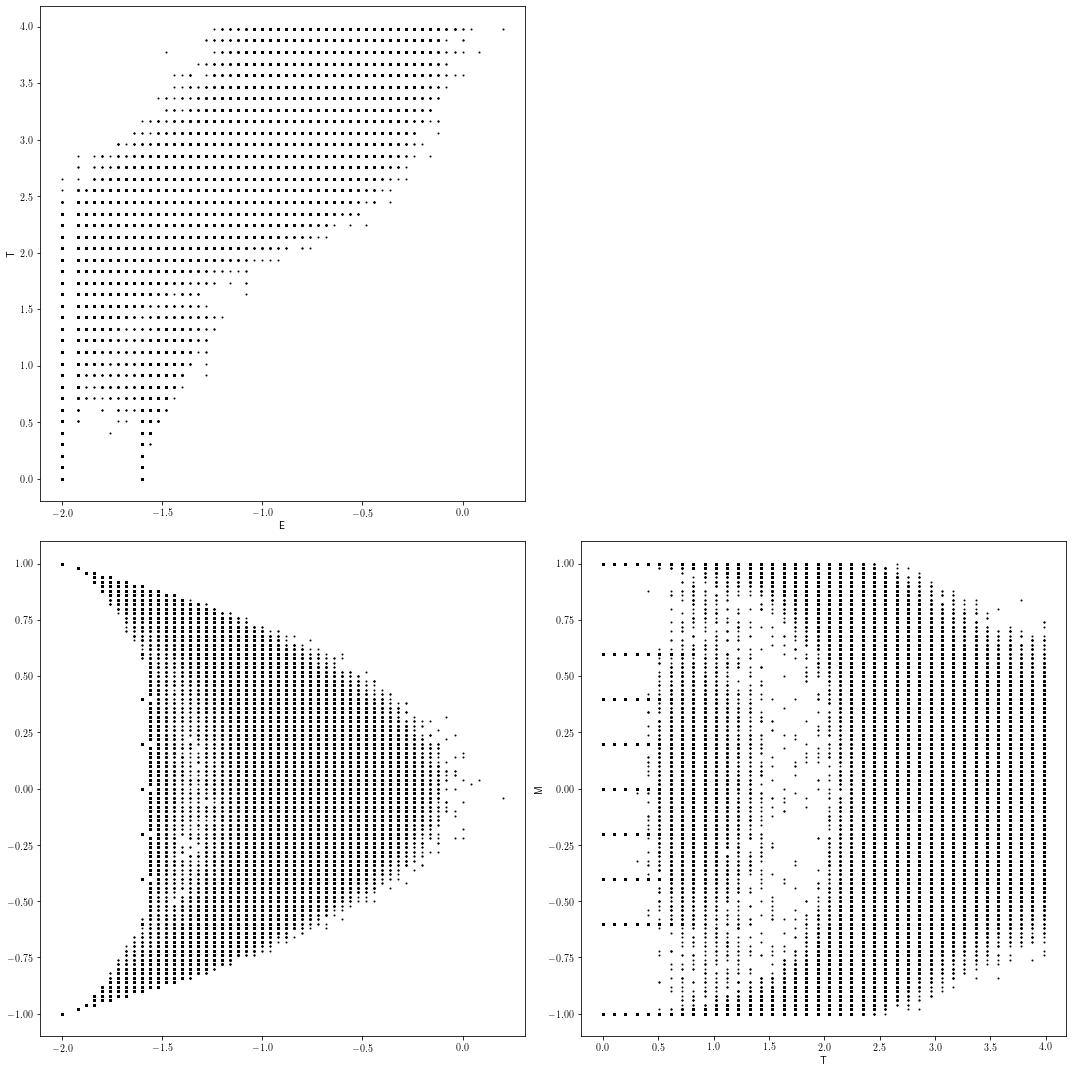

In [43]:
m2 = np.vectorize(int)(m2)
e2 = np.vectorize(int)(e2)
plt.rcParams['figure.figsize'] = (15,15)
fig = plt.figure()


ey = []
my = []
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,1))
ax3 = plt.subplot2grid((2,2), (1,0))
for t in range(40):
	ey.append([])
	my.append([])
	for n in range(10000):
		# if e2[t,n]==0:
		# 	continue
		 #remove faulty simulations
		ey[-1].append(e2[t,n]/100)
		my[-1].append(m2[t,n]/100)
	
	ax1.scatter(ey[-1], [np.linspace(0,5)[t]]*len(ey[-1]), s = 1, c = 'Black')
	ax2.scatter([np.linspace(0,5)[t]]*len(ey[-1]), my[-1], s = 1, c = 'Black')
	ax3.scatter(ey[-1],my[-1], s = 1, c = 'Black')
	
# ax1.set_aspect(1)
ax1.set_xlabel("E")
ax1.set_ylabel('T')
ax2.set_xlabel("T")
ax2.set_ylabel('M')
# ax2.set_aspect(1)
# ax3.set_aspect(1)
fig.tight_layout()

<Figure size 1080x1080 with 0 Axes>

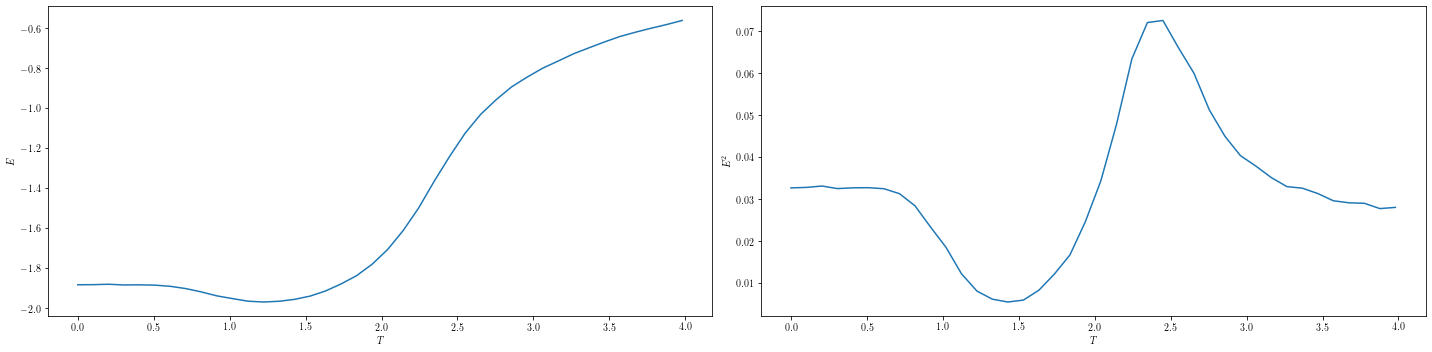

In [44]:
fig = plt.gcf()
fig, ax = plt.subplots(1,2)
ax[0].plot(np.linspace(0,5)[0:40],[statistics.mean(e) for e in ey])
ax[1].plot(np.linspace(0,5)[0:40],[statistics.variance(e) for e in ey])
ax[0].set_xlabel("$T$")
ax[0].set_ylabel("$E$")
ax[1].set_xlabel("$T$")
ax[1].set_ylabel('$E^2$')
fig = plt.gcf()
fig.set_size_inches(20, 5, forward=True)
fig.tight_layout()

In [10]:
with open('../results/46658455_magnetization_1000.csv', newline='') as csvfile:
	m2 = np.array(list(csv.reader(csvfile)))
with open('../results/46658455_energy_1000.csv', newline='') as csvfile:
	e2 = np.array(list(csv.reader(csvfile)))

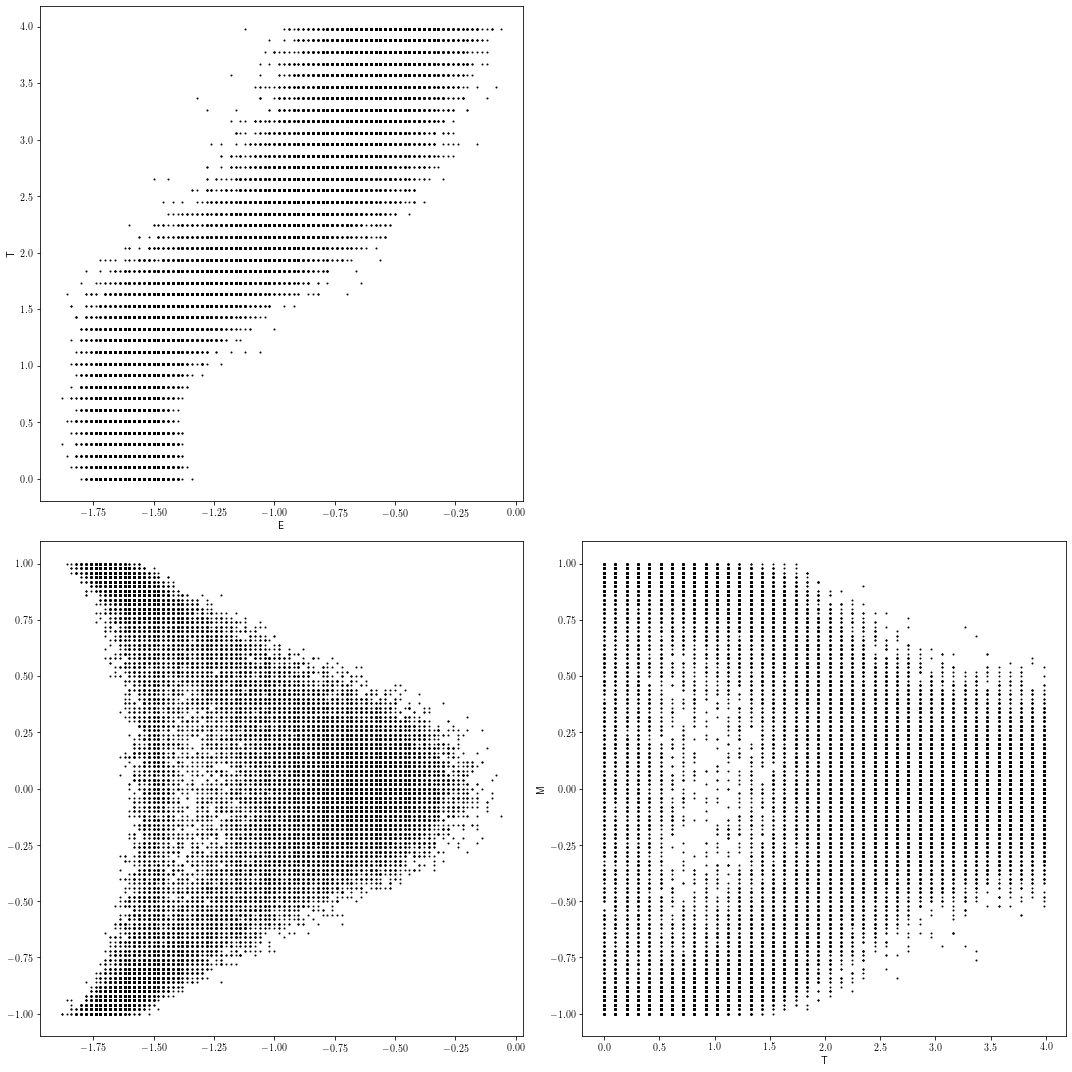

In [11]:
m2 = np.vectorize(int)(m2)
e2 = np.vectorize(int)(e2)
plt.rcParams['figure.figsize'] = (15,15)
fig = plt.figure()


ey = []
my = []
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,1))
ax3 = plt.subplot2grid((2,2), (1,0))
for t in range(40):
	ey.append([])
	my.append([])
	for n in range(1000):
		if e2[t,n]==0:
			continue
		 #remove faulty simulations
		ey[-1].append(e2[t,n]/100)
		my[-1].append(m2[t,n]/100)
	
	ax1.scatter(ey[-1], [np.linspace(0,5)[t]]*len(ey[-1]), s = 1, c = 'Black')
	ax2.scatter([np.linspace(0,5)[t]]*len(ey[-1]), my[-1], s = 1, c = 'Black')
	ax3.scatter(ey[-1],my[-1], s = 1, c = 'Black')
	
# ax1.set_aspect(1)
ax1.set_xlabel("E")
ax1.set_ylabel('T')
ax2.set_xlabel("T")
ax2.set_ylabel('M')
# ax2.set_aspect(1)
# ax3.set_aspect(1)
fig.tight_layout()

<Figure size 1080x1080 with 0 Axes>

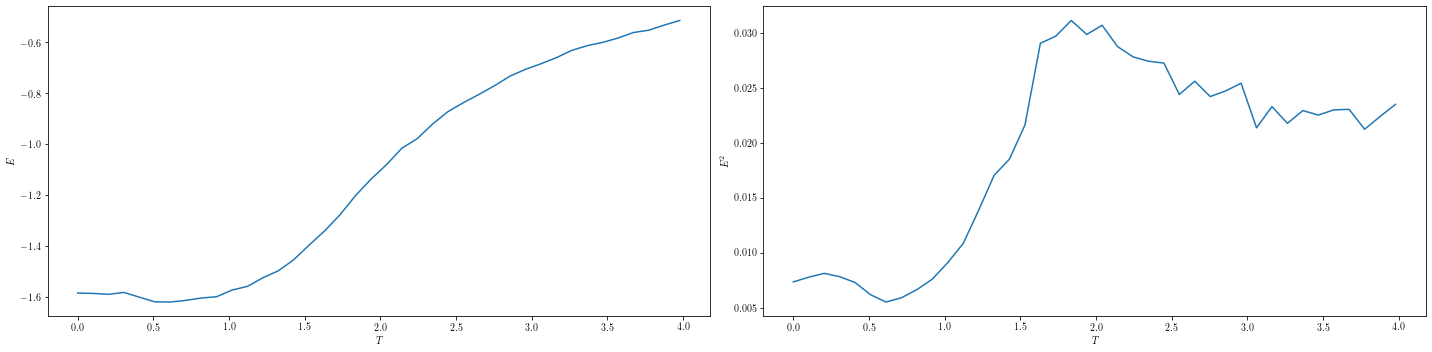

In [12]:
fig = plt.gcf()
fig, ax = plt.subplots(1,2)
ax[0].plot(np.linspace(0,5)[0:40],[statistics.mean(e) for e in ey])
ax[1].plot(np.linspace(0,5)[0:40],[statistics.variance(e) for e in ey])
ax[0].set_xlabel("$T$")
ax[0].set_ylabel("$E$")
ax[1].set_xlabel("$T$")
ax[1].set_ylabel('$E^2$')
fig = plt.gcf()
fig.set_size_inches(20, 5, forward=True)
fig.tight_layout()

In [2]:
with open('../results/46658462_magnetization_1000.csv', newline='') as csvfile:
	m2 = np.array(list(csv.reader(csvfile)))
with open('../results/46658462_energy_1000.csv', newline='') as csvfile:
	e2 = np.array(list(csv.reader(csvfile)))

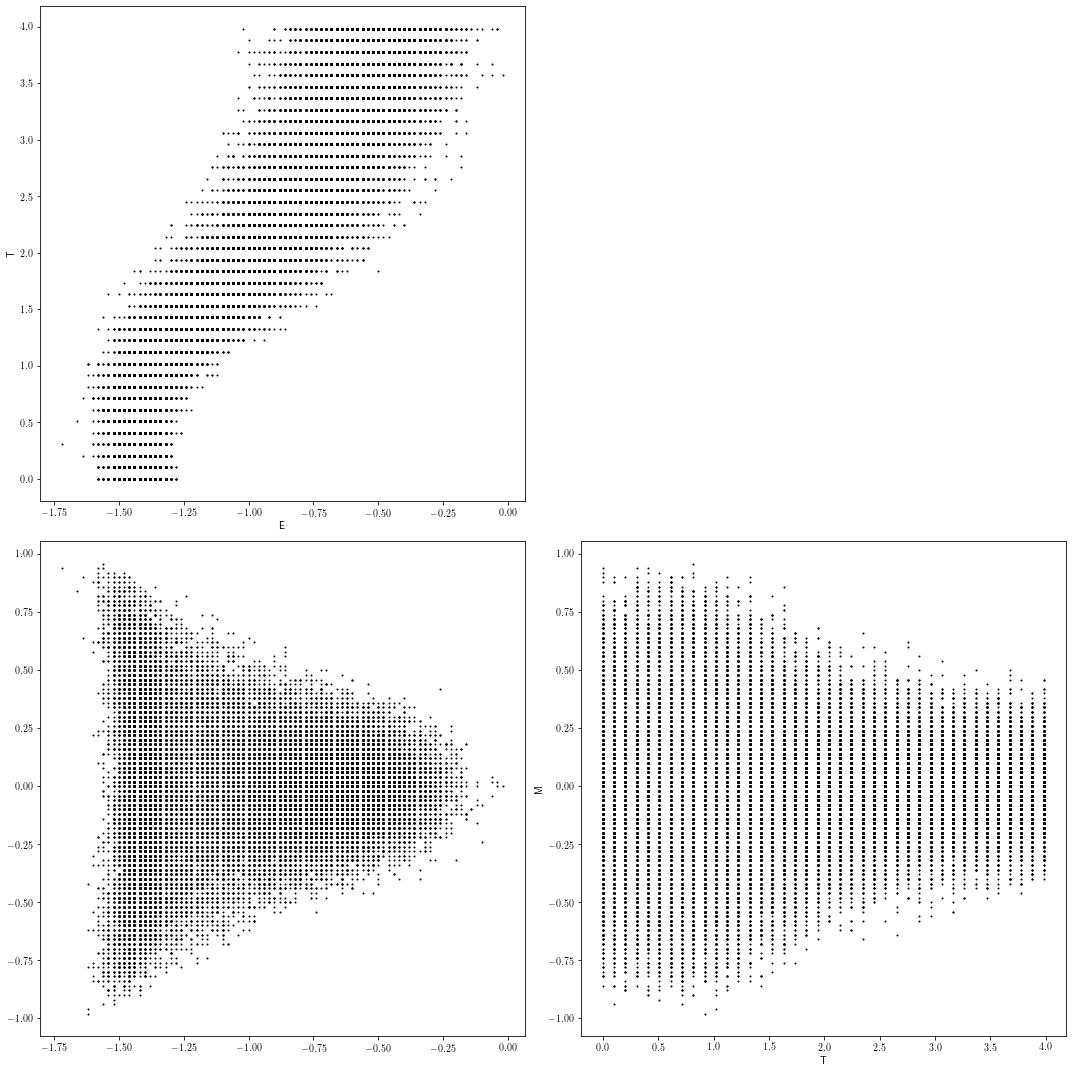

In [3]:
m2 = np.vectorize(int)(m2)
e2 = np.vectorize(int)(e2)
plt.rcParams['figure.figsize'] = (15,15)
fig = plt.figure()


ey = []
my = []
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,1))
ax3 = plt.subplot2grid((2,2), (1,0))
for t in range(40):
	ey.append([])
	my.append([])
	for n in range(1000):
		if e2[t,n]==0:
			continue
		 #remove faulty simulations
		ey[-1].append(e2[t,n]/100)
		my[-1].append(m2[t,n]/100)
	
	ax1.scatter(ey[-1], [np.linspace(0,5)[t]]*len(ey[-1]), s = 1, c = 'Black')
	ax2.scatter([np.linspace(0,5)[t]]*len(ey[-1]), my[-1], s = 1, c = 'Black')
	ax3.scatter(ey[-1],my[-1], s = 1, c = 'Black')
	
# ax1.set_aspect(1)
ax1.set_xlabel("E")
ax1.set_ylabel('T')
ax2.set_xlabel("T")
ax2.set_ylabel('M')
# ax2.set_aspect(1)
# ax3.set_aspect(1)
fig.tight_layout()

<Figure size 1080x1080 with 0 Axes>

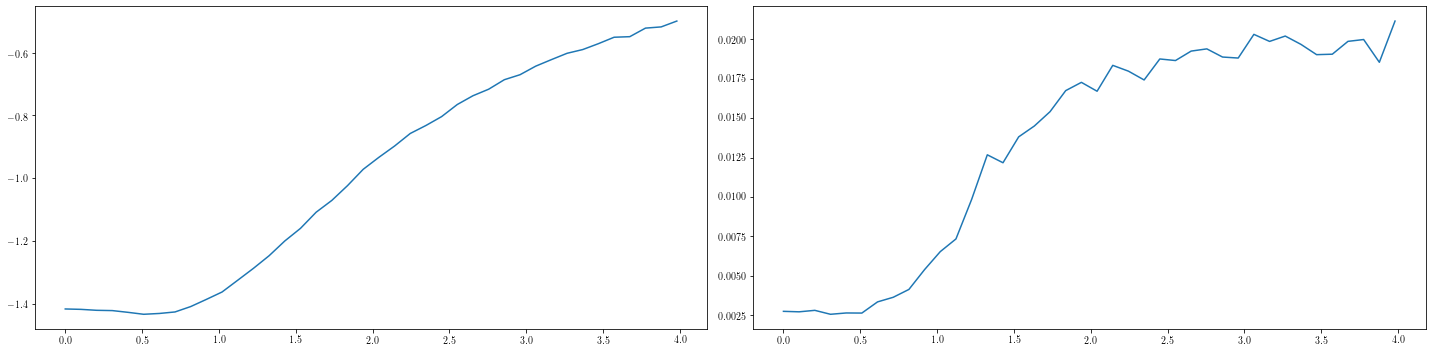

In [4]:
fig = plt.gcf()
fig, ax = plt.subplots(1,2)
ax[0].plot(np.linspace(0,5)[0:40],[statistics.mean(e) for e in ey])
ax[1].plot(np.linspace(0,5)[0:40],[statistics.variance(e) for e in ey])
ax[0].set_xlabel("$T$")
ax[0].set_ylabel("$E$")
ax[1].set_xlabel("$T$")
ax[1].set_ylabel('$E^2$')
fig = plt.gcf()
fig.set_size_inches(20, 5, forward=True)
fig.tight_layout()

In [21]:
with open('../results/46658590_magnetization_1000.csv', newline='') as csvfile:
	m2 = np.array(list(csv.reader(csvfile)))
with open('../results/46658590_energy_1000.csv', newline='') as csvfile:
	e2 = np.array(list(csv.reader(csvfile)))

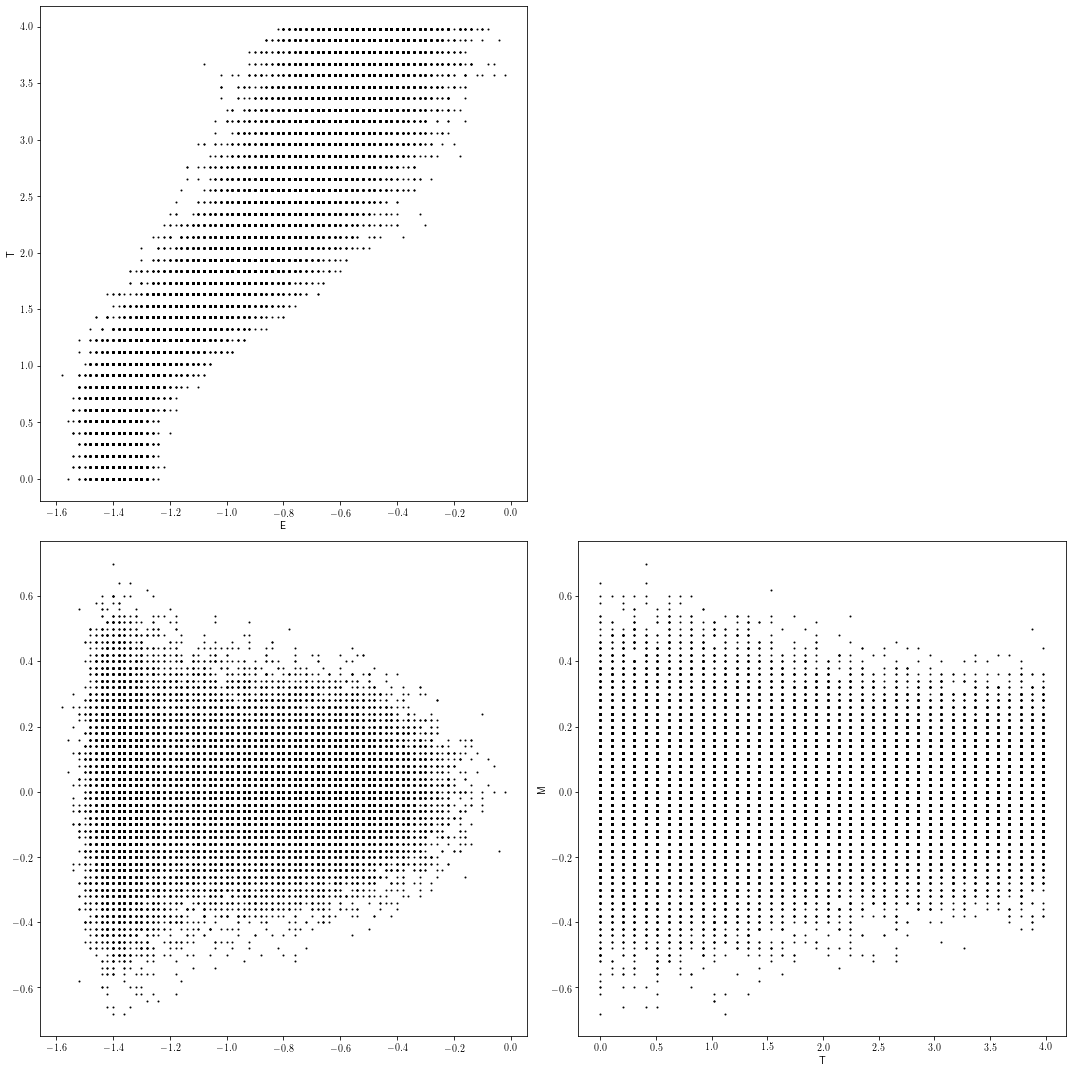

In [22]:
m2 = np.vectorize(int)(m2)
e2 = np.vectorize(int)(e2)
plt.rcParams['figure.figsize'] = (15,15)
fig = plt.figure()


ey = []``
my = []
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,1))
ax3 = plt.subplot2grid((2,2), (1,0))
for t in range(40):
	ey.append([])
	my.append([])
	for n in range(1000):
		if e2[t,n]==0:
			continue
		 #remove faulty simulations
		ey[-1].append(e2[t,n]/100)
		my[-1].append(m2[t,n]/100)
	
	ax1.scatter(ey[-1], [np.linspace(0,5)[t]]*len(ey[-1]), s = 1, c = 'Black')
	ax2.scatter([np.linspace(0,5)[t]]*len(ey[-1]), my[-1], s = 1, c = 'Black')
	ax3.scatter(ey[-1],my[-1], s = 1, c = 'Black')
	
# ax1.set_aspect(1)
ax1.set_xlabel("E")
ax1.set_ylabel('T')
ax2.set_xlabel("T")
ax2.set_ylabel('M')
# ax2.set_aspect(1)
# ax3.set_aspect(1)
fig.tight_layout()

<Figure size 1080x1080 with 0 Axes>

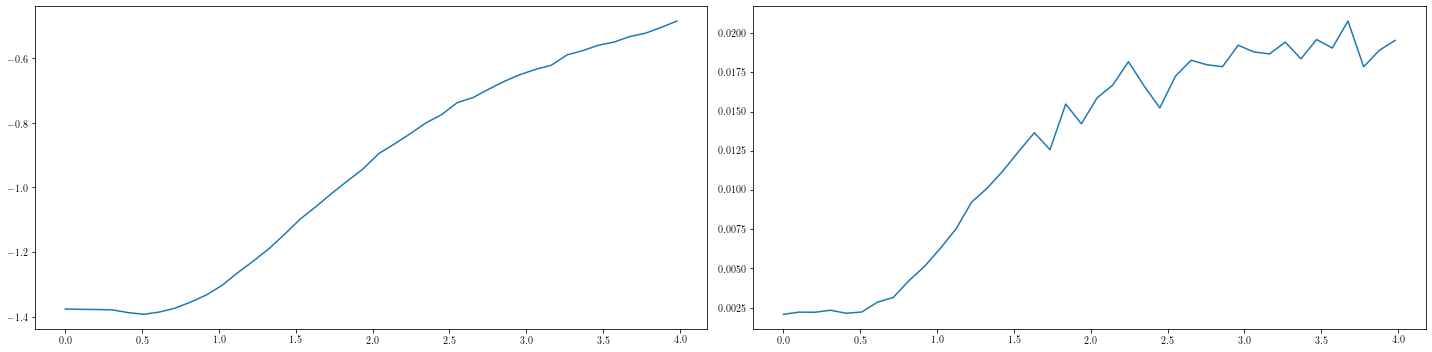

In [23]:
fig = plt.gcf()
fig, ax = plt.subplots(1,2)
ax[0].plot(np.linspace(0,5)[0:40],[statistics.mean(e) for e in ey])
ax[1].plot(np.linspace(0,5)[0:40],[statistics.variance(e) for e in ey])
ax[0].set_xlabel("$T$")
ax[0].set_ylabel("$E$")
ax[1].set_xlabel("$T$")
ax[1].set_ylabel('$E^2$')
fig = plt.gcf()
fig.set_size_inches(20, 5, forward=True)
fig.tight_layout()

## Along Nishimori Line

$e^\beta = \frac{1-p}{p}$, $\beta = \frac{1}{T}$ <br>
critical probability (error threshold): $\approx 1/2 - \tanh(1.0) \approx 11\%$

In [53]:
with open('../results/46710951_magnetization_1000.csv', newline='') as csvfile:
	m2 = np.array(list(csv.reader(csvfile)))
with open('../results/46710951_energy_1000.csv', newline='') as csvfile:
	e2 = np.array(list(csv.reader(csvfile)))

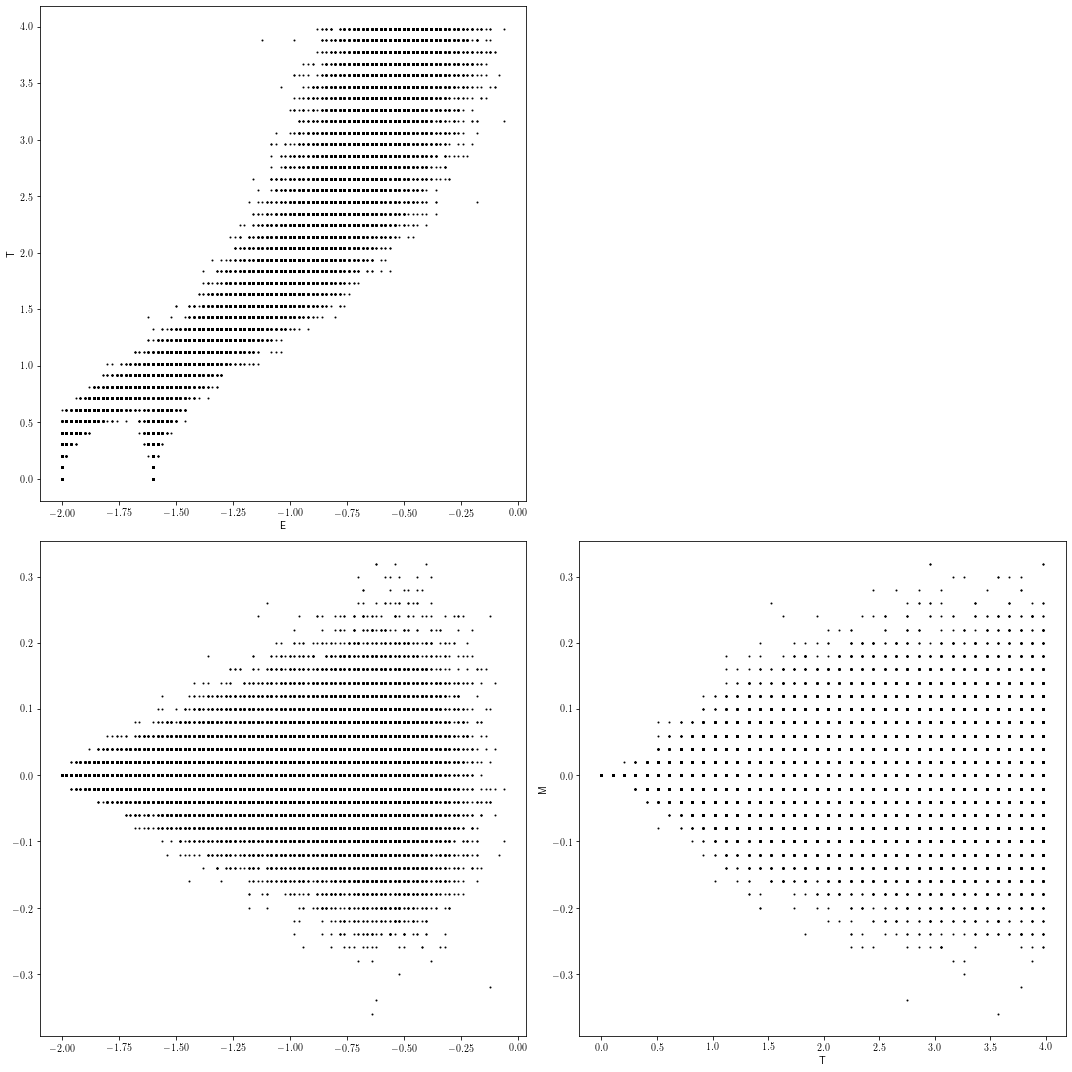

In [54]:
m2 = np.vectorize(int)(m2)
e2 = np.vectorize(int)(e2)
plt.rcParams['figure.figsize'] = (15,15)
fig = plt.figure()


ey = []
my = []
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,1))
ax3 = plt.subplot2grid((2,2), (1,0))
for t in range(40):
	ey.append([])
	my.append([])
	for n in range(1000):
		if e2[t,n]==0:
			continue
		 #remove faulty simulations
		ey[-1].append(e2[t,n]/100)
		my[-1].append(m2[t,n]/100)
	
	ax1.scatter(ey[-1], [np.linspace(0,5)[t]]*len(ey[-1]), s = 1, c = 'Black')
	ax2.scatter([np.linspace(0,5)[t]]*len(ey[-1]), my[-1], s = 1, c = 'Black')
	ax3.scatter(ey[-1],my[-1], s = 1, c = 'Black')
	
# ax1.set_aspect(1)
ax1.set_xlabel("E")
ax1.set_ylabel('T')
ax2.set_xlabel("T")
ax2.set_ylabel('M')
# ax2.set_aspect(1)
# ax3.set_aspect(1)
fig.tight_layout()

<Figure size 1080x1080 with 0 Axes>

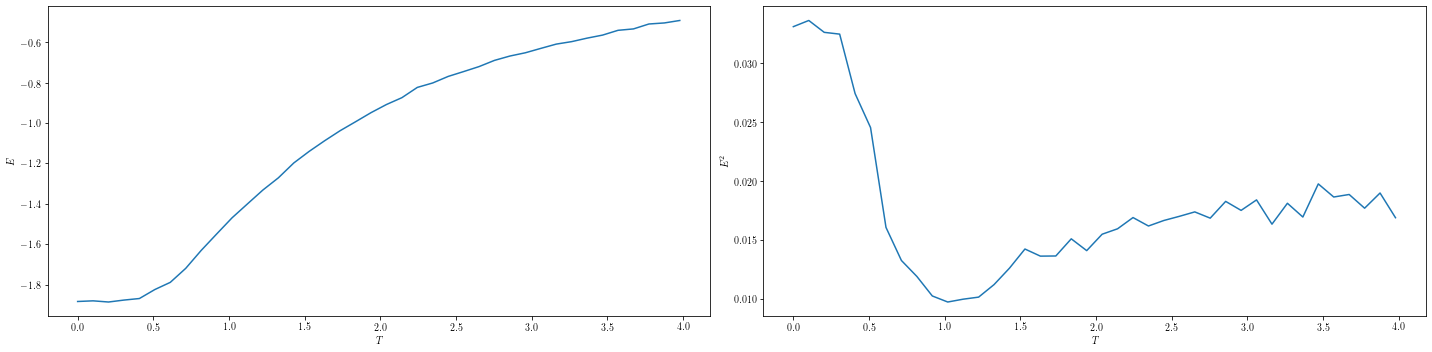

In [55]:
fig = plt.gcf()
fig, ax = plt.subplots(1,2)
ax[0].plot(np.linspace(0,5)[0:40],[statistics.mean(e) for e in ey])
ax[1].plot(np.linspace(0,5)[0:40],[statistics.variance(e) for e in ey])
ax[0].set_xlabel("$T$")
ax[0].set_ylabel("$E$")
ax[1].set_xlabel("$T$")
ax[1].set_ylabel('$E^2$')
fig = plt.gcf()
fig.set_size_inches(20, 5, forward=True)
fig.tight_layout()